# 1. MNIST分類モデルの構築とTensorBoardによる可視化

ここでは、MNISTを題材にして、TensorBoardの機能を解説します。

[Hands-on TensorBoard (TensorFlow Dev Summit 2017)](https://www.youtube.com/watch?v=eBbEDRsCmv4) をベースにしています。

## 1-1. 前準備

必要なライブラリをインポートし、MNISTのデータをダウンロードします。

MNISTは、0 から 9 までの手書き画像を分類する、有名な問題とデータ・セットのことです。画像データは全て $28\times28$ ピクセルです。
TensorFlow のチュートリアルでも利用されており、
```
tensorflow.examples.tutorials.mnist
```
に MNIST 専用の便利関数があります。MNISTのデータは $28\times28 = 786$ 次元の実数値ベクトルとして表現されています。
各画像には 0 から 9 のラベルが one hot 表現で付与されています。

In [42]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

# TensorBoardによる可視化
from google.datalab.ml._tensorboard import TensorBoard
# Jupyter Notebook 上での可視化
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style({'axes.grid' : False}) # グリッドを非表示とする

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz

label of image0: [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


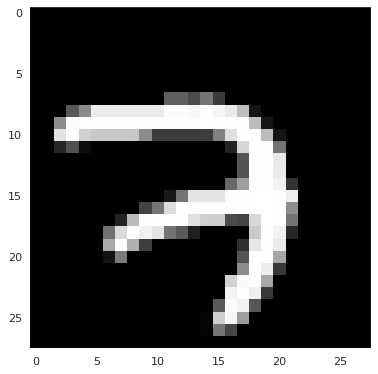

label of image1: [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]


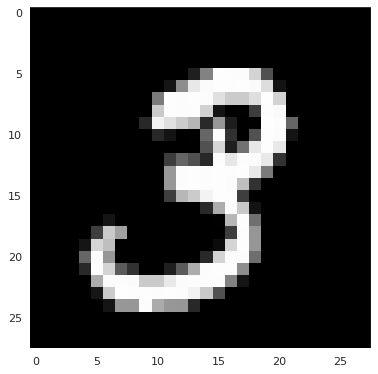

In [43]:
# MNISTのデータのダウンロードと展開
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

print
print('label of image0: {}'.format(mnist.train.labels[0]))
plt.imshow(mnist.train.images[0].reshape(28, 28), cmap='gray', interpolation='none')
plt.show()
print('label of image1: {}'.format(mnist.train.labels[1]))
plt.imshow(mnist.train.images[1].reshape(28, 28), cmap='gray', interpolation='none')
plt.show()

## 1-2. 初期モデルの構築

まずは初期モデルとして、下記のネットワークを構成します

![mnist](img/mnist_arch.png)

2つの畳み込み層と2つの全結合層をもつ、単純なネットワークです。 

まずは畳み込み層と全結合層を定義します。

In [44]:
def conv_layer(input, channels_in, channels_out):
    w = tf.Variable(tf.zeros([5, 5, channels_in, channels_out]))
    b = tf.Variable(tf.zeros([channels_out]))
    conv = tf.nn.conv2d(input, w, strides=[1, 1, 1, 1], padding="SAME")
    act = tf.nn.relu(conv + b)
    return act

def fc_layer(input, channels_in, channels_out):
    w = tf.Variable(tf.zeros([channels_in, channels_out]))
    b = tf.Variable(tf.zeros([channels_out]))
    act = tf.nn.relu(tf.matmul(input, w) + b)
    return act

次に、それらの層をつなげて、グラフを構築します。

In [45]:
x = tf.placeholder(tf.float32, shape=[None, 784])
y = tf.placeholder(tf.float32, shape=[None, 10])
x_image = tf.reshape(x, [-1, 28, 28, 1])

conv1 = conv_layer(x_image, 1, 4)
pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")
conv2 = conv_layer(pool1, 4, 8)
pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")

flattened = tf.reshape(pool2, [-1, (28/2/2)*(28/2/2)*8])
fc1 = fc_layer(flattened, flattened.get_shape()[1], 128)
logits = fc_layer(fc1, 128, 10)

cross_entropy = tf.reduce_mean(
  tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)
)
train_step = tf.train.AdamOptimizer().minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

最後に、セッションを生成して、学習のステップを進めます。

In [46]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(1, 1001):
        batch = mnist.train.next_batch(100)
        if i%250 == 0:
            train_acurracy = sess.run(accuracy, feed_dict={x: batch[0], y: batch[1]})
            print("step %d, training accuracy %g" % (i, train_acurracy))
      
    # Run the training step
    sess.run(train_step, feed_dict={x: batch[0], y: batch[1]})

step 250, training accuracy 0.09
step 500, training accuracy 0.13
step 750, training accuracy 0.14
step 1000, training accuracy 0.11


accuracy が 0.1 程度から上がらず、うまく学習できていないことがわかりました。
原因特定のため、これからTensorBoardを使ってグラフを可視化します。

## 1-2. TensorBoard によるグラフの可視化

まずはグラフを可視化します。

```
writer = tf.summary.FileWriter('logs/1')
writer.add_graph(sess.graph)
```

In [47]:
with tf.Session() as sess:
    writer = tf.summary.FileWriter('logs/1')
    writer.add_graph(sess.graph)

In [48]:
# Start TensorBoard
pid = TensorBoard.start('logs/1')

TensorBoard was started successfully with pid 19248. Click here to access it.

### TensorBoard

![TensorBoard01](img/tensorboard-01.png)

In [ ]:
# Stop TensorBoard
TensorBoard.stop(pid)

確かにグラフが可視化されましたが、とても複雑に見えます。
MNISTでこの状態なので、Inceptionなど、さらに大きなグラフの場合には解釈がとても難しくなります。
名前空間をうまく使うことで、この問題は解決できます。

## 1-3. 名前と名前空間

http://qiita.com/TomokIshii/items/ffe999b3e1a506c396c8

name_scope は variable_scope よりも汎用的。
variable_scope は変数のみ。

In [49]:
# Reset graph
tf.reset_default_graph()

In [50]:
def conv_layer(input, channels_in, channels_out, name="conv"):
  with tf.name_scope(name):  # name_scope を追加
    w = tf.Variable(tf.zeros([5, 5, channels_in, channels_out]), name="W")  # name を追加
    b = tf.Variable(tf.zeros([channels_out]), name="B")  # name を追加
    conv = tf.nn.conv2d(input, w, strides=[1, 1, 1, 1], padding="SAME")  # name を追加
    act = tf.nn.relu(conv + b)
  return act

def fc_layer(input, channels_in, channels_out, name="fc"):
  with tf.name_scope(name):  # name_scope を追加
    w = tf.Variable(tf.zeros([channels_in, channels_out]), name="W")  # name を追加
    b = tf.Variable(tf.zeros([channels_out]), name="B")  # name を追加
    act = tf.nn.relu(tf.matmul(input, w) + b)
  return act

In [51]:
x = tf.placeholder(tf.float32, shape=[None, 784], name="x")
y = tf.placeholder(tf.float32, shape=[None, 10], name="y")
x_image = tf.reshape(x, [-1, 28, 28, 1])
conv1 = conv_layer(x_image, 1, 32, "conv1")
pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")
conv2 = conv_layer(pool1, 32, 64, "conv2")
pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")

num_elements = pool2.get_shape()[1:].num_elements()
flattened = tf.reshape(pool2, [-1, num_elements])

fc1 = fc_layer(flattened, flattened.get_shape()[1], 1024, "fc1")
logits = fc_layer(fc1, 1024, 10, "fc2")

with tf.name_scope("xent"):  # name_scope を追加
  cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)
  )
with tf.name_scope("train"):  # name_scope を追加
  train_step = tf.train.AdamOptimizer().minimize(cross_entropy)
with tf.name_scope("accuracy"):  # name_scope を追加
  correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [52]:
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  
  writer = tf.summary.FileWriter('logs/2')
  writer.add_graph(sess.graph)

In [53]:
# Start TensorBoard
pid = TensorBoard.start('logs/2')

TensorBoard was started successfully with pid 19440. Click here to access it.

### TensorBoard

![TensorBoard02](img/tensorboard-02.png)

In [9]:
TensorBoard.stop(pid)

## 1-4. サマリの収集

以下の4種類の関数で summary を取得する

- tf.summary.histogram
- tf.summary.image
- tf.summary.audio
- tf.summary.tensor (under developing)


In [54]:
tf.reset_default_graph()

In [55]:
def conv_layer(input, channels_in, channels_out, name="conv"):
  with tf.name_scope(name):
    w = tf.Variable(tf.zeros([5, 5, channels_in, channels_out]), name="W")
    b = tf.Variable(tf.zeros([channels_out]), name="B")
    conv = tf.nn.conv2d(input, w, strides=[1, 1, 1, 1], padding="SAME")
    act = tf.nn.relu(conv + b)
    tf.summary.histogram("weights", w)  # 追加
    tf.summary.histogram("biases", b)  # 追加
    tf.summary.histogram("activations", act)  # 追加
  return act

def fc_layer(input, channels_in, channels_out, name="fc"):
  with tf.name_scope(name):
    w = tf.Variable(tf.zeros([channels_in, channels_out]), name="W")
    b = tf.Variable(tf.zeros([channels_out]), name="B")
    act = tf.nn.relu(tf.matmul(input, w) + b)
    tf.summary.histogram("weights", w)  # 追加
    tf.summary.histogram("biases", b)  # 追加
    tf.summary.histogram("activations", act)  # 追加
  return act

x = tf.placeholder(tf.float32, shape=[None, 784], name="x")
y = tf.placeholder(tf.float32, shape=[None, 10], name="y")
x_image = tf.reshape(x, [-1, 28, 28, 1])
tf.summary.image('input', x_image)
conv1 = conv_layer(x_image, 1, 4, "conv1")
pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")
conv2 = conv_layer(pool1, 4, 8, "conv2")
pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")

num_elements = pool2.get_shape()[1:].num_elements()
flattened = tf.reshape(pool2, [-1, num_elements])

fc1 = fc_layer(flattened, flattened.get_shape()[1], 1024, "fc1")
logits = fc_layer(fc1, 1024, 10, "fc2")

with tf.name_scope("xent"):
  cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)
  )
  tf.summary.scalar('xent', cross_entropy)  # 追加
with tf.name_scope("train"):
  train_step = tf.train.AdamOptimizer().minimize(cross_entropy)
with tf.name_scope("accuracy"):
  correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
  tf.summary.scalar('acurracy', accuracy)  # 追加

In [56]:
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  
  merged_summary = tf.summary.merge_all()
  writer = tf.summary.FileWriter('logs/3')
  writer.add_graph(sess.graph)
  
  for i in range(1, 1001):
    batch = mnist.train.next_batch(100)
    if i % 5 == 0:
      s = sess.run(merged_summary, feed_dict={x: batch[0], y: batch[1]})
      writer.add_summary(s, i)
      
    if i%250 == 0:
      train_acurracy = sess.run(accuracy, feed_dict={x: batch[0], y: batch[1]})
      print("step %d, training accuracy %g" % (i, train_acurracy))

    sess.run(train_step, feed_dict={x: batch[0], y: batch[1]})

step 250, training accuracy 0.08
step 500, training accuracy 0.09
step 750, training accuracy 0.1
step 1000, training accuracy 0.11


In [57]:
pid = TensorBoard.start('logs/3')

TensorBoard was started successfully with pid 19633. Click here to access it.

In [15]:
TensorBoard.stop(pid)

## 1-5. バグの原因の特定と解決

学習が進んでいない原因は weights や biases に tf.zeros を指定していたことが原因のように見えるので、そこを変えてみる

In [38]:
tf.reset_default_graph()

In [20]:
def conv_layer(input, channels_in, channels_out, name="conv"):
  with tf.name_scope(name):
    w = tf.Variable(tf.truncated_normal([5, 5, channels_in, channels_out], stddev=0.1), name="W")
    b = tf.Variable(tf.constant(0.1, shape=[channels_out]), name="B")
    conv = tf.nn.conv2d(input, w, strides=[1, 1, 1, 1], padding="SAME")
    act = tf.nn.relu(conv + b)
    tf.summary.histogram("weights", w)
    tf.summary.histogram("biases", b)
    tf.summary.histogram("activations", act)
  return act

def fc_layer(input, channels_in, channels_out, name="fc"):
  with tf.name_scope(name):
    w = tf.Variable(tf.truncated_normal([channels_in, channels_out], stddev=0.1), name="W")
    b = tf.Variable(tf.constant(0.1, shape=[channels_out]), name="B")
    act = tf.nn.relu(tf.matmul(input, w) + b)
    tf.summary.histogram("weights", w)
    tf.summary.histogram("biases", b)
    tf.summary.histogram("activations", act)
  return act

x = tf.placeholder(tf.float32, shape=[None, 784], name="x")
y = tf.placeholder(tf.float32, shape=[None, 10], name="y")
x_image = tf.reshape(x, [-1, 28, 28, 1])
tf.summary.image('input', x_image)
conv1 = conv_layer(x_image, 1, 4, "conv1")
pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")
conv2 = conv_layer(pool1, 4, 8, "conv2")
pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")

num_elements = pool2.get_shape()[1:].num_elements()
flattened = tf.reshape(pool2, [-1, num_elements])
flattened_dim = int(flattened.get_shape()[1])

fc1 = fc_layer(flattened, flattened_dim, 1024, "fc1")
logits = fc_layer(fc1, 1024, 10, "fc2")

with tf.name_scope("xent"):
  cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)
  )
  tf.summary.scalar('xent', cross_entropy)
with tf.name_scope("train"):
  train_step = tf.train.AdamOptimizer().minimize(cross_entropy)
with tf.name_scope("accuracy"):
  correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
  tf.summary.scalar('acurracy', accuracy)

In [22]:
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  
  merged_summary = tf.summary.merge_all()
  writer = tf.summary.FileWriter('logs/4')
  writer.add_graph(sess.graph)
  
  for i in range(1, 1001):
    batch = mnist.train.next_batch(100)
    if i % 5 == 0:
      s = sess.run(merged_summary, feed_dict={x: batch[0], y: batch[1]})
      writer.add_summary(s, i)
      
    if i%250 == 0:
      train_acurracy = sess.run(accuracy, feed_dict={x: batch[0], y: batch[1]})
      print("step %d, training accuracy %g" % (i, train_acurracy))

    sess.run(train_step, feed_dict={x: batch[0], y: batch[1]})

step 250, training accuracy 0.47
step 500, training accuracy 0.65
step 750, training accuracy 0.62
step 1000, training accuracy 0.53


In [ ]:
pid = TensorBoard.start('logs/4')

In [ ]:
TensorBoard.stop(pid)

## Then, Tuning HyperParameters

次にパラメータのチューニングをしていきます。
実は TensorBoard は指定されたディレクトリを再帰的に読みに行きます。

In [ ]:
pid = TensorBoard.start('logs/hparams')
# TensorBoard was started successfully with pid 13166. Click here to access it.

In [24]:
def run_mnist(learning_rate, n_fc_layers, n_conv_layers, writer):
  tf.reset_default_graph()
  x = tf.placeholder(tf.float32, shape=[None, 784], name="x")
  y = tf.placeholder(tf.float32, shape=[None, 10], name="y")
  x_image = tf.reshape(x, [-1, 28, 28, 1])
  
  in_ = x_image
  for layer in range(n_conv_layers):
    channels_in = int(in_.get_shape()[-1])
    channels_out = 2**(layer + 1)
    conv = conv_layer(in_, channels_in, channels_out, "conv{}".format(layer))
    pool = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")
    in_ = pool
    
  num_elements = in_.get_shape()[1:].num_elements()
  flattened = tf.reshape(in_, [-1, num_elements])
  
  in_ = flattened
  for layer in range(n_fc_layers):
    channels_in = int(in_.get_shape()[-1])
    channels_out = 1024
    fc = fc_layer(in_, channels_in, channels_out, "fc{}".format(layer))
    in_ = fc

  logits = fc_layer(in_, 1024, 10, "fc{}".format(n_fc_layers))
  
  with tf.name_scope("xent"):
    cross_entropy = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)
    )
    tf.summary.scalar('xent', cross_entropy)
  with tf.name_scope("train"):
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
  with tf.name_scope("accuracy"):
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar('acurracy', accuracy)
    
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
  
    merged_summary = tf.summary.merge_all()
    writer.add_graph(sess.graph)
  
    for i in range(1, 2001):
      batch = mnist.train.next_batch(100)
      if i % 5 == 0:
        s = sess.run(merged_summary, feed_dict={x: batch[0], y: batch[1]})
        writer.add_summary(s, i)
      
      if i%250 == 0:
        train_acurracy = sess.run(accuracy, feed_dict={x: batch[0], y: batch[1]})
        print("step %d, training accuracy %g" % (i, train_acurracy))

      sess.run(train_step, feed_dict={x: batch[0], y: batch[1]})

In [25]:
for learning_rate in [1e-4, 1e-2, 1]:
  for n_fc_layers in [1, 2]:
    for n_conv_layers in [1, 2]:
      description = '{}_{}_{}'.format(learning_rate, n_fc_layers, n_conv_layers)
      writer = tf.summary.FileWriter('logs/hparams/{}'.format(description))
      print(description)
      run_mnist(learning_rate, n_fc_layers, n_conv_layers, writer)

0.0001_1_1
step 250, training accuracy 0.56
step 500, training accuracy 0.71
step 750, training accuracy 0.71
step 1000, training accuracy 0.72
step 1250, training accuracy 0.68
step 1500, training accuracy 0.76
step 1750, training accuracy 0.67
step 2000, training accuracy 0.65
0.0001_1_2
step 250, training accuracy 0.71
step 500, training accuracy 0.82
step 750, training accuracy 0.8
step 1000, training accuracy 0.78
step 1250, training accuracy 0.8
step 1500, training accuracy 0.85
step 1750, training accuracy 0.81
step 2000, training accuracy 0.85
0.0001_2_1
step 250, training accuracy 0.38
step 500, training accuracy 0.39
step 750, training accuracy 0.49
step 1000, training accuracy 0.46
step 1250, training accuracy 0.56
step 1500, training accuracy 0.54
step 1750, training accuracy 0.44
step 2000, training accuracy 0.46
0.0001_2_2
step 250, training accuracy 0.61
step 500, training accuracy 0.7
step 750, training accuracy 0.75
step 1000, training accuracy 0.81
step 1250, training

In [ ]:
TensorBoard.list()